In [39]:
import numpy as np
import matplotlib.pyplot as plt
import galpy as gp
from galpy.orbit import Orbit
from galpy.potential import *
from astropy import units as u
import wurlitzer
from galpy.util import bovy_conversion
import matplotlib as mpl
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import pickle
from datetime import datetime
from operator import itemgetter
from matplotlib.animation import FuncAnimation

In [40]:
from amuse.lab import *
from amuse.couple import bridge
from amuse.support.literature import LiteratureReferencesMixIn
from amuse.datamodel import Particles
from amuse.ext.bridge import bridge

from amuse.units import units
from amuse.units import quantities
from amuse.units import constants
from amuse.units import nbody_system
from amuse.ext.bridge import bridge
from amuse.community.ph4.interface import ph4
from amuse.community.fi.interface import Fi
from amuse.community.bhtree.interface import BHTree
from amuse.community.gadget2.interface import Gadget2
from amuse.ic.kingmodel import new_king_model
from amuse.support.literature import LiteratureReferencesMixIn

In [3]:
%load_ext wurlitzer

In [4]:
%matplotlib nbagg

# Define all dwarf galaxies

In [5]:
ts = np.linspace(0., -12/bovy_conversion.time_in_Gyr(ro=8.,vo=220.), 1201)
dt = (ts[1]-ts[0])/250

# SAGITTARIUS
sgr_M = 1.4E10*u.Msun
sgr_a = 7*u.kpc # 6.5kpc from https://arxiv.org/pdf/1608.04743.pdf
sgr_pot = HernquistPotential(amp=sgr_M, a=sgr_a, ro=8., vo=220.)
sgr_orbit = Orbit(vxvv=[283.8313, -30.5453, 26.67, -2.692, -1.359, 140], radec=True, ro=8.,vo=220.) 
sgr_orbit.integrate(ts, MWPotential2014, dt=dt)
sgr_potential = MovingObjectPotential(sgr_orbit, pot=sgr_pot)

# LMC
lmc_M = 1E11*u.Msun # https://arxiv.org/pdf/1608.04743.pdf
lmc_a = 10.2*u.kpc  # https://iopscience.iop.org/article/10.1088/2041-8205/721/2/L97/pdf
lmc_pot = HernquistPotential(amp=lmc_M, a=lmc_a, ro=8., vo=220.)
lmc_orbit = Orbit(vxvv=[78.77, -69.01, 50.1, 1.850, 0.234, 262.2], radec=True, ro=8.,vo=220.) 
lmc_orbit.integrate(ts, MWPotential2014, dt=dt)
lmc_potential = MovingObjectPotential(lmc_orbit, pot=lmc_pot)

# SMC
smc_M = 2.6E10*u.Msun # https://iopscience.iop.org/article/10.1088/2041-8205/721/2/L97/pdf
smc_a = 3.6*u.kpc     # https://iopscience.iop.org/article/10.1088/2041-8205/721/2/L97/pdf
smc_pot = HernquistPotential(amp=smc_M, a=smc_a, ro=8., vo=220.)
smc_orbit = Orbit(vxvv=[16.26, -72.42, 62.8, 0.797, -1.220, 145.6], radec=True, ro=8.,vo=220.) 
smc_orbit.integrate(ts, MWPotential2014, dt=dt)
smc_potential = MovingObjectPotential(smc_orbit, pot=smc_pot)

# FORNAX
fnx_M = 2E9*u.Msun # https://academic.oup.com/mnras/article/368/3/1073/1022509
fnx_a = 3.4*u.kpc  # https://academic.oup.com/mnras/article-pdf/368/3/1073/18665310/mnras0368-1073.pdf
fnx_pot = HernquistPotential(amp=fnx_M, a=fnx_a)
fnx_orbit = Orbit(vxvv=[39.962, -34.511, 139.3, 0.374, -0.401, 55.3], radec=True, ro=8.,vo=220.) 
fnx_orbit.integrate(ts, MWPotential2014, dt=dt)
fnx_potential = MovingObjectPotential(fnx_orbit, pot=fnx_pot)

# DRACO
dra_M = 6.3E9*u.Msun # https://iopscience.iop.org/article/10.1086/521543/pdf
dra_a = 7*u.kpc # https://iopscience.iop.org/article/10.1086/521543/pdf
dra_pot = HernquistPotential(amp=dra_M, a=dra_a)
dra_orbit = Orbit(vxvv=[260.06, 57.965, 79.07, -0.012, -0.158, -291], radec=True, ro=8.,vo=220.) 
dra_orbit.integrate(ts, MWPotential2014, dt=dt)
dra_potential = MovingObjectPotential(dra_orbit, pot=dra_pot)

# URSA MINOR
umi_M = 2.5E9*u.Msun # https://iopscience.iop.org/article/10.1086/521543/pdf
umi_a = 5.4*u.kpc    # https://iopscience.iop.org/article/10.1086/521543/pdf
umi_pot = HernquistPotential(amp=umi_M, a=umi_a)
umi_orbit = Orbit(vxvv=[227.242, 67.222, 75.86, -0.184, 0.082, -246.9], radec=True, ro=8.,vo=220.) 
umi_orbit.integrate(ts, MWPotential2014, dt=dt)
umi_potential = MovingObjectPotential(umi_orbit, pot=umi_pot)

satellites_pot = [sgr_potential, lmc_potential, smc_potential, fnx_potential, dra_potential, umi_potential]
total_pot = [sgr_potential, lmc_potential, smc_potential, fnx_potential, dra_potential, umi_potential, MWPotential2014]

# Define AMUSE functions

In [6]:
class galpy_profile(LiteratureReferencesMixIn):
    """
    User-defined potential from GALPY

    .. [#] Bovy, J; ApJSS, Volume 216, Issue 2, article id. 29, 27 pp. (2015)

    """
    def __init__(self,pot, t = 0. | units.Gyr, tgalpy = 0. | units.Gyr, ro=8, vo=220.):
        LiteratureReferencesMixIn.__init__(self)
        self.ro=ro
        self.vo=vo
        self.fconv = bovy_conversion.force_in_kmsMyr(ro=self.ro,vo=self.vo)
        self.pot = pot
        self.model_time=t
        self.tstart = tgalpy
        self.tgalpy = tgalpy.value_in(units.Gyr)/bovy_conversion.time_in_Gyr(ro=8.,vo=220.)

    def evolve_model(self,t_end):
        self.model_time=t_end
        self.tgalpy=(self.tstart+t_end).value_in(units.Gyr)/bovy_conversion.time_in_Gyr(ro=8.,vo=220.)

    def get_potential_at_point(self,eps,x,y,z):

        R=np.sqrt(x.value_in(units.kpc)**2.+y.value_in(units.kpc)**2.)
        zed=z.value_in(units.kpc)
        phi=np.arctan2(y.value_in(units.kpc),x.value_in(units.kpc))

        pot=gp.potential.evaluatePotentials(self.pot,R/self.ro,zed/self.ro,phi=phi,t=self.tgalpy,ro=self.ro,vo=self.vo) | units.km**2*units.s**-2

        return pot

    def get_gravity_at_point(self,eps,x,y,z, t=0|units.Gyr):

        R=np.sqrt(x.value_in(units.kpc)**2.+y.value_in(units.kpc)**2.)
        zed=z.value_in(units.kpc)
        phi=np.arctan2(y.value_in(units.kpc),x.value_in(units.kpc))
        Rnorm = R/self.ro
        znorm = zed/self.ro

        Rforce=gp.potential.evaluateRforces(self.pot,Rnorm,znorm,phi=phi,t=self.tgalpy)
        phiforce=gp.potential.evaluatephiforces(self.pot,Rnorm,znorm,phi=phi,t=self.tgalpy)/(Rnorm)
        zforce=gp.potential.evaluatezforces(self.pot,Rnorm,znorm,phi=phi,t=self.tgalpy)

        cosphi = np.cos(phi)
        sinphi = np.sin(phi)

        ax=(Rforce*cosphi-phiforce*sinphi)*self.fconv | units.kms * units.myr**-1
        ay=(Rforce*sinphi+phiforce*cosphi)*self.fconv | units.kms * units.myr**-1
        az=zforce*self.fconv | units.kms * units.myr**-1

        return ax,ay,az

    def circular_velocity(self,r):
        vcirc=gp.potential.vcirc(self.pot,r.value_in(units.kpc)/self.ro,phi=0,ro=self.ro,vo=self.vo) | units.kms
        return vcirc

    def stop(self):
        pass

In [7]:
def setup_cluster(nbodycode,N,Mcluster,Rcluster,Rinit,Vinit, parameters = []):

    converter=nbody_system.nbody_to_si(Mcluster,Rcluster)
    stars=new_plummer_sphere(N,converter)

    stars.x += Rinit[0]
    stars.y += Rinit[1]
    stars.z += Rinit[2]
    stars.vx += Vinit[0]
    stars.vy += Vinit[1]
    stars.vz += Vinit[2]

    code=nbodycode(converter, number_of_workers=1)
    for name,value in parameters:
        setattr(code.parameters, name, value)
    code.particles.add_particles(stars)
    return code

In [8]:
def evolve_cluster_in_galaxy(N, pot, Rinit, Vinit, tstart, tend, dtout, timestep, M, R):
    galaxy_code = galpy_profile(pot, tgalpy=tstart)

    cluster_code = setup_cluster(BHTree,
                                 N,
                                 Mcluster,
                                 Rcluster,
                                 Rinit,
                                 Vinit,
                                 parameters=[("epsilon_squared",(0.1 | units.parsec)**2),
                                             ("timestep", 0.1 | units.Myr),
                                             ("opening_angle", 0.6)])


    stars = cluster_code.particles.copy()
    num = int(abs(tstart.value_in(units.Myr)/dtout.value_in(units.Myr)))+1
    particles = []

    channel_from_stars_to_cluster_code=stars.new_channel_to(cluster_code.particles, attributes=["x", "y", "z", "vx", "vy", "vz"])
    channel_from_cluster_code_to_stars=cluster_code.particles.new_channel_to(stars, attributes=["x", "y", "z", "vx", "vy", "vz"])

    system = bridge(verbose=False)
    system.add_system(cluster_code, (galaxy_code,))
    system.add_system(galaxy_code)

    times = quantities.arange(0|units.Myr, tend-tstart, timestep)
    for i,t in enumerate(times):
        if (t.value_in(units.Myr)%dtout.value_in(units.Myr) < timestep.value_in(units.Myr)):
            print(t)
            particles.append([cluster_code.particles.position, cluster_code.particles.velocity])
        system.evolve_model(t, timestep=timestep)

    particles.append([cluster_code.particles.position, cluster_code.particles.velocity])
    cluster_code.stop()

    return particles

In [9]:
t_max = -12.
times = np.array([0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -11.999])
n_steps = 1201

orb = Orbit.from_name("NGC5466")
orb.integrate(ts, total_pot)

In [10]:
o = orb.getOrbit()
pars = o[-1]
new_orbit = Orbit(vxvv=pars, ro=8.,vo=220.)
ts_plus=np.linspace(0,12,1201)*u.Gyr # Gyr
new_orbit.integrate(ts_plus, MWPotential2014)

In [11]:
a = [new_orbit.r(t) for t in ts_plus]
ind = min(enumerate(a), key=itemgetter(1))[0]
loc = new_orbit.getOrbit()[ind]*[8, 220, 220, 8, 220, 1]
rt_peri = gp.potential.rtide(MWPotential2014, R=loc[0], z=loc[3], phi=loc[5], M=10**5.5*u.Msun)

In [12]:
t0 = -1.*u.Gyr # start time
Rinit=[orb.x(t0), orb.y(t0),orb.z(t0)] | units.kpc
Vinit=[orb.vx(t0),orb.vy(t0),orb.vz(t0)] | units.km/units.s

In [13]:
r_h = 0.145*rt_peri
r_p = r_h/1.3

In [14]:
N=1000                          # Number of stars in the cluster
timestep= 0.5 | units.Myr       # Timestep to update potential+move cluster
starttime = -1000 | units.Myr   # Simulation begins
endtime = -1. | units.Myr       # Simuation ends
dtout = 10. | units.Myr         # Time to output dataset
Mcluster = 2*10**5 | units.MSun # Total mass of the cluster
Rcluster = r_p | units.kpc      # Initial Plummer radius

# Simulate with dwarf galaxies

In [15]:
start_time = datetime.now()
particles_DG = evolve_cluster_in_galaxy(N, total_pot, Rinit, Vinit, starttime, endtime, dtout, timestep, Mcluster, Rcluster)
print("Done.")
print("Took:", datetime.now()-start_time)

0.0 Myr
10.0 Myr
20.0 Myr
30.0 Myr
40.0 Myr
50.0 Myr
60.0 Myr
70.0 Myr
80.0 Myr
90.0 Myr
100.0 Myr
110.0 Myr
120.0 Myr
130.0 Myr
140.0 Myr
150.0 Myr
160.0 Myr
170.0 Myr
180.0 Myr
190.0 Myr
200.0 Myr
210.0 Myr
220.0 Myr
230.0 Myr
240.0 Myr
250.0 Myr
260.0 Myr
270.0 Myr
280.0 Myr
290.0 Myr
300.0 Myr
310.0 Myr
320.0 Myr
330.0 Myr
340.0 Myr
350.0 Myr
360.0 Myr
370.0 Myr
380.0 Myr
390.0 Myr
400.0 Myr
410.0 Myr
420.0 Myr
430.0 Myr
440.0 Myr
450.0 Myr
460.0 Myr
470.0 Myr
480.0 Myr
490.0 Myr
500.0 Myr
510.0 Myr
520.0 Myr
530.0 Myr
540.0 Myr
550.0 Myr
560.0 Myr
570.0 Myr
580.0 Myr
590.0 Myr
600.0 Myr
610.0 Myr
620.0 Myr
630.0 Myr
640.0 Myr
650.0 Myr
660.0 Myr
670.0 Myr
680.0 Myr
690.0 Myr
700.0 Myr
710.0 Myr
720.0 Myr
730.0 Myr
740.0 Myr
750.0 Myr
760.0 Myr
770.0 Myr
780.0 Myr
790.0 Myr
800.0 Myr
810.0 Myr
820.0 Myr
830.0 Myr
840.0 Myr
850.0 Myr
860.0 Myr
870.0 Myr
880.0 Myr
890.0 Myr
900.0 Myr
910.0 Myr
920.0 Myr
930.0 Myr
940.0 Myr
950.0 Myr
960.0 Myr
970.0 Myr
980.0 Myr
990.0 Myr
Done.
Took:

# Simulate in Milky Way

In [16]:
start_time = datetime.now()
particles_MW = evolve_cluster_in_galaxy(N, MWPotential2014, Rinit, Vinit, starttime, endtime, dtout, timestep, Mcluster, Rcluster)
print("Done.")
print("Took:", datetime.now()-start_time)

0.0 Myr
10.0 Myr
20.0 Myr
30.0 Myr
40.0 Myr
50.0 Myr
60.0 Myr
70.0 Myr
80.0 Myr
90.0 Myr
100.0 Myr
110.0 Myr
120.0 Myr
130.0 Myr
140.0 Myr
150.0 Myr
160.0 Myr
170.0 Myr
180.0 Myr
190.0 Myr
200.0 Myr
210.0 Myr
220.0 Myr
230.0 Myr
240.0 Myr
250.0 Myr
260.0 Myr
270.0 Myr
280.0 Myr
290.0 Myr
300.0 Myr
310.0 Myr
320.0 Myr
330.0 Myr
340.0 Myr
350.0 Myr
360.0 Myr
370.0 Myr
380.0 Myr
390.0 Myr
400.0 Myr
410.0 Myr
420.0 Myr
430.0 Myr
440.0 Myr
450.0 Myr
460.0 Myr
470.0 Myr
480.0 Myr
490.0 Myr
500.0 Myr
510.0 Myr
520.0 Myr
530.0 Myr
540.0 Myr
550.0 Myr
560.0 Myr
570.0 Myr
580.0 Myr
590.0 Myr
600.0 Myr
610.0 Myr
620.0 Myr
630.0 Myr
640.0 Myr
650.0 Myr
660.0 Myr
670.0 Myr
680.0 Myr
690.0 Myr
700.0 Myr
710.0 Myr
720.0 Myr
730.0 Myr
740.0 Myr
750.0 Myr
760.0 Myr
770.0 Myr
780.0 Myr
790.0 Myr
800.0 Myr
810.0 Myr
820.0 Myr
830.0 Myr
840.0 Myr
850.0 Myr
860.0 Myr
870.0 Myr
880.0 Myr
890.0 Myr
900.0 Myr
910.0 Myr
920.0 Myr
930.0 Myr
940.0 Myr
950.0 Myr
960.0 Myr
970.0 Myr
980.0 Myr
990.0 Myr
Done.
Took:

# Save/load the dataset array as a pickle
The simulations take a long time and this way the particle datasets can be saved as a file and accessed later.

In [ ]:
name = "NGC5466.pickle"
with open(name, 'wb') as handle:
    pickle.dump(particles_DG, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('NGC5466.pickle', 'rb') as handle:
    particles = pickle.load(handle)

# Get centre of mass

In [17]:
def get_CoM(particles):
    x = particles[:, 0].value_in(units.kpc)
    y = particles[:, 1].value_in(units.kpc)
    z = particles[:, 2].value_in(units.kpc)
    CoM = np.zeros((len(x), 3))
    xyz = np.vstack([x, y, z])
    kde = stats.gaussian_kde(xyz)
    density = kde(xyz)
    CoM = xyz.T[np.argmax(density)]

    return CoM

In [18]:
CoM_MW = np.array([get_CoM(p[0]) for p in particles_MW])
CoM_DG = np.array([get_CoM(p[0]) for p in particles_DG])

<IPython.core.display.Javascript object>


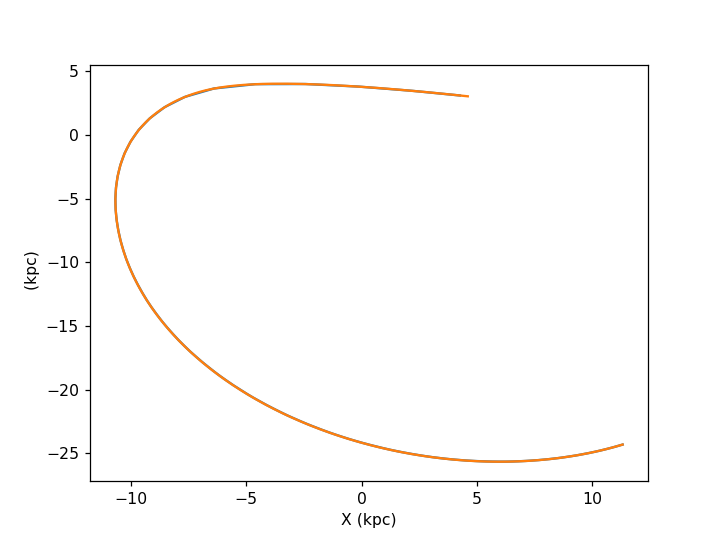

In [19]:
fig, ax = plt.subplots()
t_s = np.linspace(t0.value, -0, 1001)*u.Gyr
plt.plot(CoM_DG[:, 0], CoM_DG[:, 1])
plt.plot(orb.x(t_s), orb.y(t_s))
plt.xlabel("X (kpc)")
plt.ylabel(" (kpc)")
plt.show() # Shows that the galpy and AMUSE orbit are the same

# Get distance of closest approach

In [20]:
def min_distance(p, dwarf_o=sgr_orbit, tstart=-0.1*u.Gyr, tend=-0.01*u.Gyr, n=1000):
    ts = np.linspace(tstart, tend, n)
    i_s = ((1-ts.value/t0.value)*len(p)).astype(int)
    ts = ts.value/bovy_conversion.time_in_Gyr(ro=8, vo=220)
    zs = np.array(list(zip(ts, i_s)))
    
    dx = np.array([dwarf_o.x(zi[0])-p[int(zi[1])][0][:, 0].value_in(units.kpc) for zi in zs])
    dy = np.array([dwarf_o.y(zi[0])-p[int(zi[1])][0][:, 1].value_in(units.kpc) for zi in zs])
    dz = np.array([dwarf_o.z(zi[0])-p[int(zi[1])][0][:, 2].value_in(units.kpc) for zi in zs])
    ds = (dx**2+dy**2+dz**2)**0.5
    
    minn = np.amin(ds)
    result = np.where(ds == minn)
    return minn, ts[result[0]][0]*bovy_conversion.time_in_Gyr(ro=8, vo=220)*u.Gyr

In [21]:
d_sgr, t_sgr = min_distance(particles_DG, sgr_orbit)
d_smc, t_smc = min_distance(particles_DG, smc_orbit)
d_lmc, t_lmc = min_distance(particles_DG, lmc_orbit)
print("Sgr comes within", d_sgr, "kpc of the tidal stream at time:", t_sgr)
print("SMC comes within", d_smc, "kpc of the tidal stream at time:", t_smc)
print("LMC comes within", d_lmc, "kpc of the tidal stream at time:", t_lmc)

Sgr comes within 8.289455093914587 kpc of the tidal stream at time: -0.04954954954954955 Gyr
SMC comes within 38.261273660451124 kpc of the tidal stream at time: -0.0990990990990991 Gyr
LMC comes within 25.3894263470976 kpc of the tidal stream at time: -0.0990990990990991 Gyr


# 3D scatter plot of particles

<IPython.core.display.Javascript object>


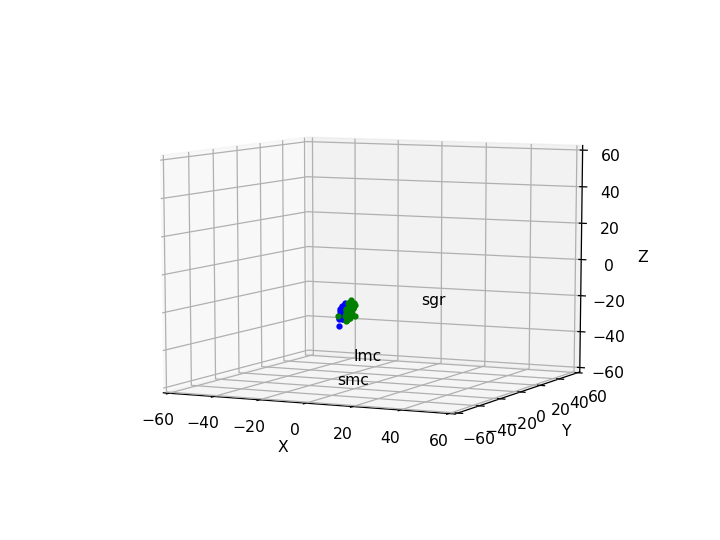

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

t=-0.120*u.Gyr
i = int((1-t.value/t0.value)*len(particles_DG))

ax.plot(particles_MW[i][0][:, 0].value_in(units.kpc),
        particles_MW[i][0][:, 1].value_in(units.kpc),
        particles_MW[i][0][:, 2].value_in(units.kpc),
        'b.')

ax.plot(particles_DG[i][0][:, 0].value_in(units.kpc),
        particles_DG[i][0][:, 1].value_in(units.kpc),
        particles_DG[i][0][:, 2].value_in(units.kpc),
        'g.')

ax.text(sgr_orbit.x(t), sgr_orbit.y(t), sgr_orbit.z(t), 'sgr')
ax.text(lmc_orbit.x(t), lmc_orbit.y(t), lmc_orbit.z(t), 'lmc')
ax.text(smc_orbit.x(t), smc_orbit.y(t), smc_orbit.z(t), 'smc')
ax.set_xlim3d(-60, 60)
ax.set_ylim3d(-60, 60)
ax.set_zlim3d(-60, 60)

plt.show()

# 2D density plot

In [23]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#00204e'),
                                                    (0.125, '#472775'),
                                                    (0.25, '#3c4f8a'),
                                                    (0.375, '#2d6e8e'),
                                                    (0.5, '#218f8d'),
                                                    (0.625, '#27ab82'),
                                                    (1., '#fde725')
                                                    ])
cmap.set_bad('#00204e')

<IPython.core.display.Javascript object>


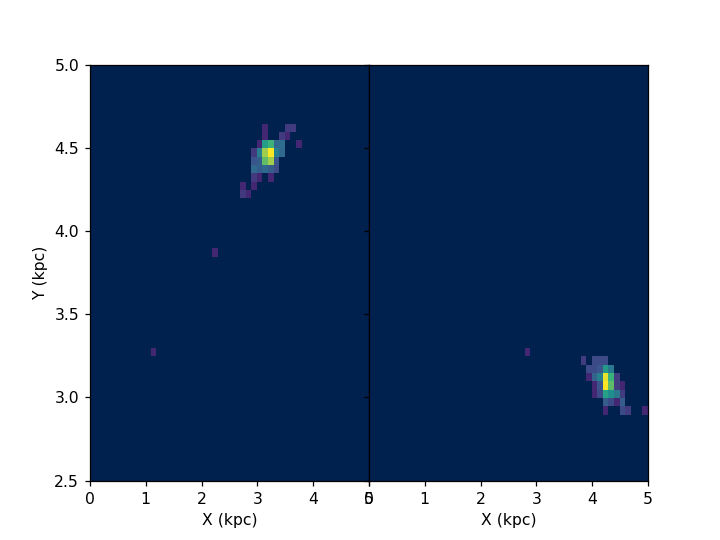

In [24]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.subplots_adjust(wspace=0)
r = ((0, 5),(2.5, 5))

h = ax[0].hist2d(particles_MW[-1][0][:, 0].value_in(units.kpc), 
           particles_MW[-1][0][:, 1].value_in(units.kpc),
           bins=50,range=r,cmap=cmap, norm = mpl.colors.LogNorm())

ax[1].hist2d(particles_DG[-1][0][:, 0].value_in(units.kpc), 
           particles_DG[-1][0][:, 1].value_in(units.kpc),
           bins=50,range=r,cmap=cmap, norm = mpl.colors.LogNorm())


ax[0].set_xlabel("X (kpc)")
ax[1].set_xlabel("X (kpc)")
ax[0].set_ylabel("Y (kpc)")

fig.savefig('ESO28006_dwarf_xy.png', dpi=300)
plt.show()

# Animation!

<IPython.core.display.Javascript object>


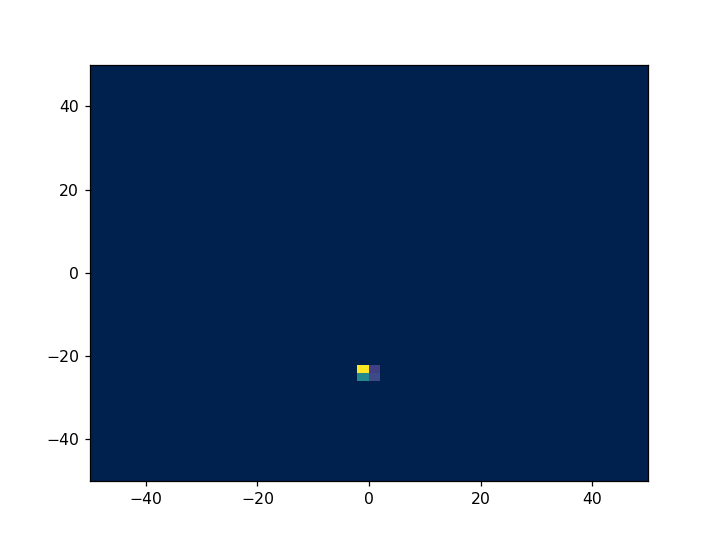

In [25]:
fig, ax = plt.subplots()
r = ((-50,50),(-50, 50))

data = particles_DG

def update_hist(n):
    plt.cla()
    ax.hist2d(data[n][0][:, 0].value_in(units.kpc), 
           data[n][0][:, 1].value_in(units.kpc),
           bins=50,range=r,cmap=cmap, norm = mpl.colors.LogNorm())

h = ax.hist2d(data[0][0][:, 0].value_in(units.kpc), 
           data[0][0][:, 1].value_in(units.kpc),
           bins=50,range=r,cmap=cmap, norm = mpl.colors.LogNorm())

ani = FuncAnimation(fig, update_hist, len(data))
ani.save('animation.gif', writer='imagemagick', fps=30)

plt.show()

# Mass loss plot

In [26]:
def mass_within_rtide(n, particles, CoM):
    x = particles[:, 0].value_in(units.kpc)
    y = particles[:, 1].value_in(units.kpc)
    z = particles[:, 2].value_in(units.kpc)
    
    R = (x**2+y**2)**0.5
    rtide = gp.potential.rtide(MWPotential2014, R=R, z=z, M=1E6*u.Msun)
    R = ((x-CoM[0])**2+(y-CoM[1])**2+(z-CoM[2])**2)**.5
    return (R < n*rtide).sum()/len(particles)

In [27]:
M_rt_MW = [mass_within_rtide(2., particles_MW[i][0], CoM_MW[i]) for i in range(len(particles_MW))]
M_rt_DG = [mass_within_rtide(2., particles_DG[i][0], CoM_DG[i]) for i in range(len(particles_DG))]

<IPython.core.display.Javascript object>


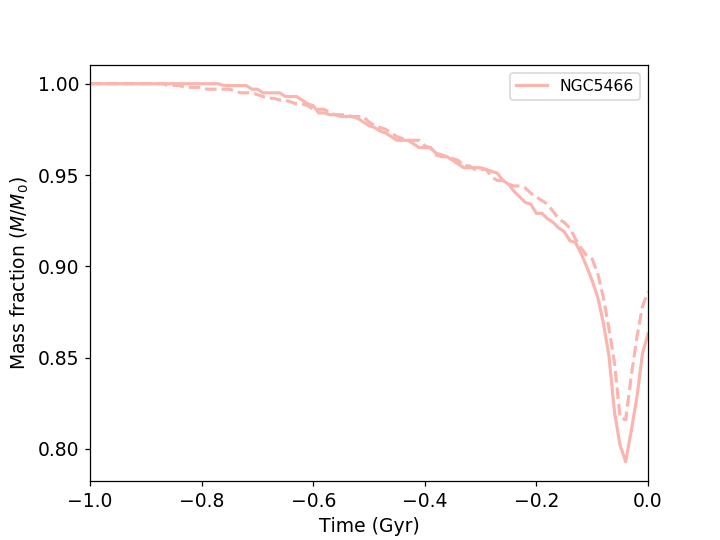

In [28]:
fig, ax = plt.subplots()
ls = np.linspace(-1, 0, len(particles_MW))
ax.invert_xaxis()

plt.plot(ls, M_rt_MW, c='#fbb4ae', linewidth=2, label="NGC5466")
plt.plot(ls, M_rt_DG, c='#fbb4ae', linestyle='dashed', linewidth=2)

plt.xlabel("Time (Gyr)", fontsize=12)
plt.ylabel("Mass fraction ($M/M_0$)", fontsize=12)
ax.tick_params(labelsize=12)
plt.xlim(t0.value, 0)
plt.legend()
fig.savefig('mass_loss.png', dpi=300)
plt.show()

# Half-mass radius

In [29]:
def half_mass_radius(particles, CoM):
    x = particles[:, 0].value_in(units.kpc)
    y = particles[:, 1].value_in(units.kpc)
    z = particles[:, 2].value_in(units.kpc)
    
    R = (x**2+y**2)**0.5
    rtide = gp.potential.rtide(MWPotential2014, R=R, z=z, M=1E6*u.Msun)
    r_star = ((x-CoM[0])**2+(y-CoM[1])**2+(z-CoM[2])**2)**.5
    M_cluster = (r_star < 2.*rtide).sum()
    
    ind = int(M_cluster/2.)
    
    p = sorted(particles, key=lambda p: (p[0].value_in(units.kpc)-CoM[0])**2+
                                        (p[1].value_in(units.kpc)-CoM[1])**2+
                                        (p[2].value_in(units.kpc)-CoM[2])**2)
    
    hmr = ((p[ind][0].value_in(units.kpc)-CoM[0])**2+
           (p[ind][1].value_in(units.kpc)-CoM[1])**2+
           (p[ind][2].value_in(units.kpc)-CoM[2])**2)**.5

    return hmr

In [30]:
R_hm_MW = [half_mass_radius(particles_MW[i][0], CoM_MW[i]) for i in range(len(particles_MW))]
R_hm_DG = [half_mass_radius(particles_DG[i][0], CoM_DG[i]) for i in range(len(particles_DG))]

<IPython.core.display.Javascript object>


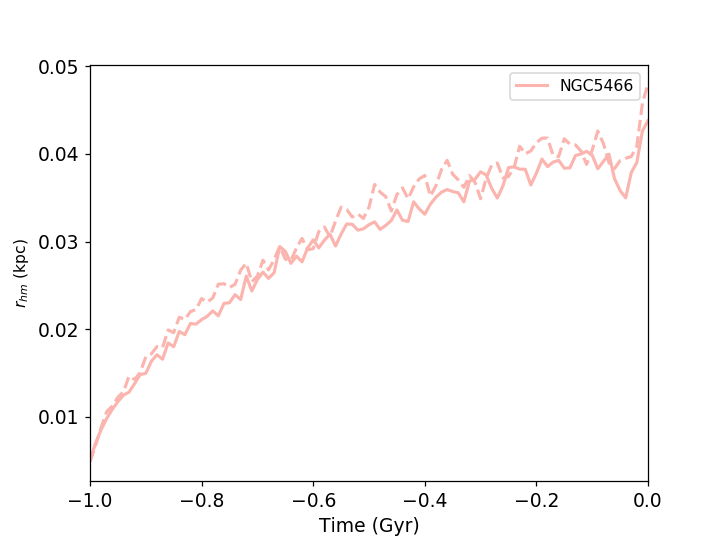

In [31]:
fig, ax = plt.subplots()
ls = np.linspace(-1, 0, len(particles_MW))
ax.invert_xaxis()

plt.plot(ls, R_hm_MW, c='#fbb4ae', linewidth=2, label="NGC5466")
plt.plot(ls, R_hm_DG, c='#fbb4ae', linestyle='dashed', linewidth=2)

plt.xlabel("Time (Gyr)", fontsize=12)
plt.ylabel("$r_{hm}$ (kpc)")
ax.tick_params(labelsize=12)
plt.xlim(t0.value, 0)
plt.legend()
fig.savefig('half_mass_radius.png', dpi=300)
plt.show()